# Shortest path function

This notebook will set up a function for the shortest path between two points. This can then be used in the different algorithm to find the shortest path (including travel time) between the road inspector and the incident

In [1]:
%matplotlib inline
import geopandas as gpd
import folium 
import json
import pandas as pd
import numpy as np

from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import branca.colormap as cm
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.collections as mcoll
from distinctipy import distinctipy

import pickle
import networkx as nx
from scipy import spatial

In [2]:
def WGS84toDutchRD(wgs84East, wgs84North):
    # translated from Peter Knoppers's code

    # wgs84East: longtitude
    # wgs84North: latitude

    # Western boundary of the Dutch RD system. */
    WGS84_WEST_LIMIT = 3.2

    # Eastern boundary of the Dutch RD system. */
    WGS84_EAST_LIMIT = 7.3

    # Northern boundary of the Dutch RD system. */
    WGS84_SOUTH_LIMIT = 50.6

    # Southern boundary of the Dutch RD system. */
    WGS84_NORTH_LIMIT = 53.7

    if (wgs84North > WGS84_NORTH_LIMIT) or \
        (wgs84North < WGS84_SOUTH_LIMIT) or \
        (wgs84East < WGS84_WEST_LIMIT) or \
        (wgs84East > WGS84_EAST_LIMIT):
        resultX = -1
        resultY = -1
    else:
        r = [[155000.00, 190094.945,   -0.008, -32.391, 0.0],
            [-0.705, -11832.228,    0.0  ,   0.608, 0.0],
            [0.0  ,   -114.221,    0.0  ,   0.148, 0.0],
            [0.0  ,     -2.340,    0.0  ,   0.0  , 0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  , 0.0]]
        s = [[463000.00 ,      0.433, 3638.893,   0.0  ,  0.092],
            [309056.544,     -0.032, -157.984,   0.0  , -0.054],
            [73.077,      0.0  ,   -6.439,   0.0  ,  0.0],
            [59.788,      0.0  ,    0.0  ,   0.0  ,  0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  ,  0.0]]
        resultX = 0
        resultY = 0
        powNorth = 1
        dNorth = 0.36 * (wgs84North - 52.15517440)
        dEast = 0.36 * (wgs84East - 5.38720621)

        for p in range(5):
            powEast = 1
            for q in range(5):
                resultX = resultX + r[p][q] * powEast * powNorth
                resultY = resultY + s[p][q] * powEast * powNorth
                powEast = powEast * dEast
            powNorth = powNorth * dNorth
    return resultX, resultY

Load in data

In [3]:
G = pickle.load(open('NetworkX_graph_new.pickle', 'rb'))

Function to calculate the travel time between two points. The points do not need to be on the network. The nearest node on the networkX graph will be determined. The function can be used for normal travel time and peak hour travel time

In [4]:
# travel_time function
def travel_time_func(point1, point2, time='min'):
    """This function uses the information given in network X to return the travel time between two points.
        point1 and point2 should be tuples with the coordinates in longitude, latitude.
        if time = 'peak', the peak travel time is used. In all other cases the minimum travel time is used."""

    # Determine which travel times to use
    if time == 'peak':
        time_string = 'Peak_travel_time_[s]'
    else:
        time_string = 'Min_travel_time_[s]'

    # Change points to Dutch system
    p1_x, p1_y = WGS84toDutchRD(point1[0], point1[1]) # inspector
    p2_x, p2_y = WGS84toDutchRD(point2[0], point2[1]) # incident

    # Create numpy matrix from nodes
    A = np.array(list(G.nodes()))

    # Get node closest to each point
    dist_node1, index_node1 = spatial.KDTree(A).query([p1_x, p1_y])
    node1 = (A[index_node1][0], A[index_node1][1])

    dist_node2, index_node2 = spatial.KDTree(A).query([p2_x, p2_y])
    node2 = (A[index_node2][0], A[index_node2][1])

    # Get shortest path between nodes
    route = nx.shortest_path(G, node1, node2, time_string)
    travel_time = nx.shortest_path_length(G, node1, node2, time_string)

    return route, travel_time

Now, the incidents data is imported so random points from that data can be used to test the algorithm

In [5]:
incidents = pd.read_csv('Dashboard_data\incidents_data', sep=';')

In [6]:
p1 = (incidents.iloc[0].longitude, incidents.iloc[0].latitude)
p2 = (incidents.iloc[6391].longitude, incidents.iloc[6391].latitude)

In [7]:
short_path, time = travel_time_func(p1, p2)

Plot a simple figure between the two points

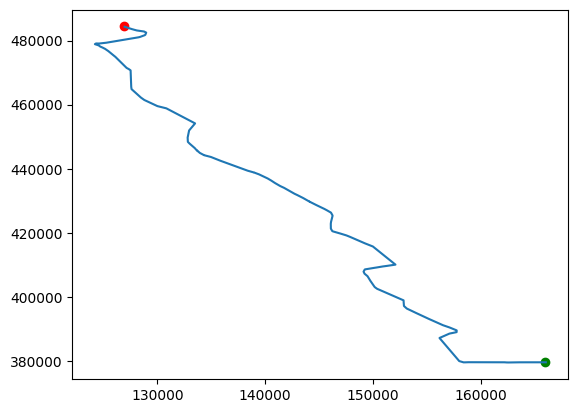

In [8]:
plt.figure()
short_path, time = travel_time_func(p1, p2)
B = np.array(short_path)

plt.plot(B[:, 0], B[:, 1])
plt.scatter(WGS84toDutchRD(p1[0], p1[1])[0], WGS84toDutchRD(p1[0], p1[1])[1], color='r')
plt.scatter(WGS84toDutchRD(p2[0], p2[1])[0], WGS84toDutchRD(p2[0], p2[1])[1], color='g')

The algorithms assumes that the distance between the actual location and the node can be neglected. 

In [19]:
distances = np.zeros(len(incidents))
A = np.array(list(G.nodes()))

for i in range(len(incidents)):
    p1, p2 = incidents.iloc[i].longitude, incidents.iloc[i].latitude
    p_x, p_y = WGS84toDutchRD(p1, p2)
    dist_node, _ = spatial.KDTree(A).query([p_x, p_y])

    distances[i] = dist_node

Assuming a speed of 120 km/h:
On average, it takes: 9.1 s to reach the nearest node
The median travel time to the nearest node is: 3.4 s


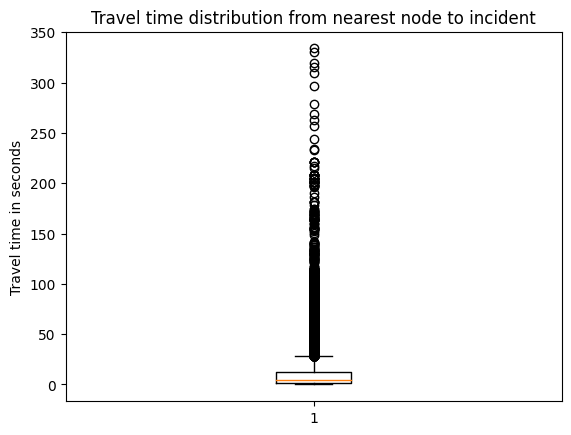

In [34]:
plt.title('Travel time distribution from nearest node to incident')
plt.boxplot(distances / (100 / 3.6))
plt.ylabel('Travel time in seconds')

print('Assuming a speed of 120 km/h:')
print(f'On average, it takes: {np.mean(distances) / (120 / 3.6):.1f} s to reach the nearest node')
print(f'The median travel time to the nearest node is: {np.median(distances) / (120 / 3.6):.1f} s')

So the average and median distance between the actual location of the incident and the node is not much, though there are a few outliers. Those few seconds don't make much of a difference when looking at a travel time of 18 minutes, so it is assumed it can be neglected. (Sometimes these seconds should be added to the travel time, and sometimes subtracted, depending on which route is chosen, so it is assumed that those travel times even out on average.)

Now, some functions will be written to show the path on the map and some other visualizations. 

In [11]:
edges_arr = np.array(list(G.edges()))

In [12]:
def plot_network(G):
    """Returns fig, ax of a subplot containing the road network of NL
    This can be used to plot other things like shortest path or clusters of an inspector"""
    
    # Make array containing all edges from network G
    edges_arr = np.array(list(G.edges()))

    # Make a figure
    fig, ax = plt.subplots()
    fig.set_figheight(9)

    # Add edges from network to LineCollection object
    line_segments = mcoll.LineCollection(edges_arr, colors='cornflowerblue')
    ax.add_collection(line_segments)

    # Set limits and scale of figure
    ax.set(xlim=(np.min(edges_arr[:, :, 0]),np.max(edges_arr[:, :, 0])), 
        ylim=(np.min(edges_arr[:, :, 1]),np.max(edges_arr[:, :, 1])))

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    return fig, ax

In [13]:
def plot_shortest_path(p1, p2, time_str='minimum', G=G):
    """This function plots the shortest path between two paths.

        point1 and point2 should be tuples with the coordinates in longitude, latitude
        if time = 'peak', the peak travel time is used. In all other cases the minimum travel time is used."""

    # Create figure with NL road network
    fig, ax = plot_network(G)

    # Calculate shortest path
    short_path, times = travel_time_func(p1, p2, time=time_str)
    B = np.array(short_path)

    # Make string of travel time
    tt = f'{times//60:.0f} minutes and {times%60:.0f} seconds'

    # Plot shortest path
    ax.plot(B[:, 0], B[:, 1], color='red', label=f'Shortest path: {tt}')
    ax.scatter(WGS84toDutchRD(p1[0], p1[1])[0], WGS84toDutchRD(p1[0], p1[1])[1], color='green', label='start point')
    ax.scatter(WGS84toDutchRD(p2[0], p2[1])[0], WGS84toDutchRD(p2[0], p2[1])[1], color='maroon', label='End point')

    ax.set_title(f'Shortest path for {time_str} travel time')

    ax.legend()

    return fig

In [24]:
def plot_area_inspector(cluster, inspector_loc, time_to_incident, time_str='minimum', G=G):
    """Color roads that certain inspector is responsible for
    cluster is a integer. Make sure it is not larger than the no. of inspectors in dataset
    The coordinates in time_to_incident have to be in WGS84 coordinates"""

    # Create figure with NL road network
    fig, ax = plot_network(G)

    if cluster == 'all':
        colors = distinctipy.get_colors(len(inspector_loc), pastel_factor=0.6)

        for i in range(len(inspector_loc)):
            loc_inspector = WGS84toDutchRD(inspector_loc.loc[i]['1'], inspector_loc.loc[i]['0'])
    
            # Get coordinates for all incidents in the cluster
            coor = np.array(time_to_incident[time_to_incident['2'] == i + 1])

            # Plot the cluster
            ax.scatter(coor[:, 0], coor[:, 1], s=2, zorder=2, color=colors[i])
            
            # Plot inspector point
            ax.scatter(loc_inspector[0], loc_inspector[1], color='red', zorder=2)
        
        ax.set_title('Different areas of each inspector for method 1 with minimum travel times')
        ax.plot(0, 0, color='cornflowerblue', label='roads without incidents')
        ax.scatter(0, 0, color=colors[-1], label='Colored roads are areas of inspectors')
        ax.scatter(0, 0, color='red', label='Location of inspectors')
        ax.legend()

    else:
        # Get right coordinates for inspectors
        loc_inspector = WGS84toDutchRD(inspector_loc.loc[cluster - 1]['1'], inspector_loc.loc[cluster - 1]['0'])
        
        # Get coordinates for all incidents in the cluster
        coor = np.array(time_to_incident[time_to_incident['2'] == cluster])

        # Plot the cluster
        ax.scatter(coor[:, 0], coor[:, 1], s=2, zorder=2, color='salmon')
        ax.scatter(0, 0, s=2, color='salmon', label='Incidents within reach')

        # Plot inspector point
        ax.scatter(loc_inspector[0], loc_inspector[1], color='red', zorder=2)
        ax.legend()
        ax.set_title(f'Area of inspector {cluster} for method 1 with minimum travel times')

    ax.scatter(0, 0, color='red', label='Location of inspector')
    return fig



Import results from k-means clustering method by distance. These results will be used to visualize the areas of the inspector on the map

In [25]:
cluster_min_inspector_loc = pd.read_csv('Dashboard_data\Optimization_results\cluster_min_inspector_locations.csv', sep=';')
cluster_min_travel_time = pd.read_csv('Dashboard_data\Optimization_results\cluster_min_travel_time_to_incident.csv', sep=';')

cluster_peak_inspector_loc = pd.read_csv('Dashboard_data\Optimization_results\cluster_peak_inspector_locations.csv', sep=';')
cluster_peak_travel_time = pd.read_csv('Dashboard_data\Optimization_results\cluster_peak_travel_time_to_incident.csv', sep=';')

In [26]:
colors = distinctipy.get_colors(len(cluster_min_inspector_loc), pastel_factor=0.6)

In [27]:
coordinate_update = cluster_min_travel_time[['longitude', 'latitude', 'cluster']]
new_coor = np.zeros((len(coordinate_update), 3))

for i in range(len(coordinate_update)):
    lon = coordinate_update.iloc[i]['longitude']
    lat = coordinate_update.iloc[i]['latitude']

    x, y = WGS84toDutchRD(lon, lat)
    new_coor[i] = [x, y, coordinate_update.iloc[i]['cluster']]

df = pd.DataFrame(new_coor)
df.to_csv('Dashboard_data\cluster_min_traveltime_WGS84')
min_traveltime_WGS84 = pd.read_csv('Dashboard_data\cluster_min_traveltime_WGS84', index_col=0)

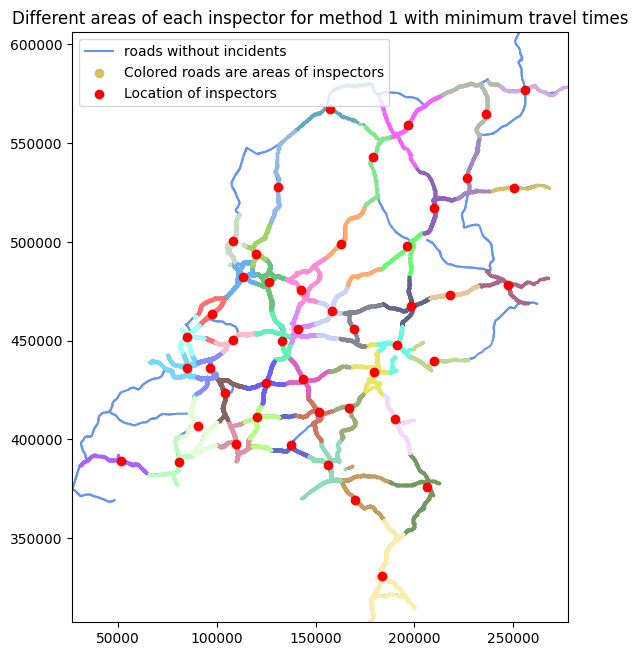

In [28]:
fig = plot_area_inspector('all', cluster_min_inspector_loc, min_traveltime_WGS84, time_str='minimum', G=G)

In [29]:
fig.savefig('Dashboard_data\Inspectorareas.png')

Plot two shortest paths during peak hour time and with the minimum travel time, to see the differences. These different paths are similar to the different routes "Google maps" shows when trying to find a route by car. This has been tested for several random routes, to see if the results were realistic.

In [30]:
p1 = (incidents.iloc[0].longitude, incidents.iloc[0].latitude)
p2 = (incidents.iloc[52543].longitude, incidents.iloc[52543].latitude)

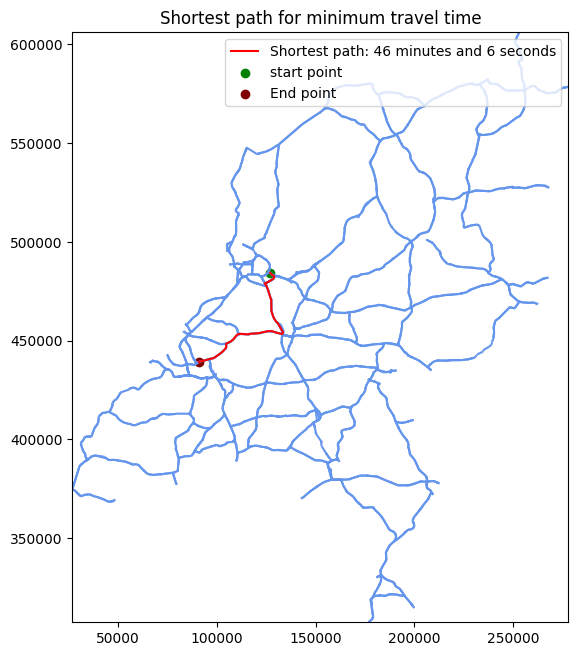

In [31]:
fig = plot_shortest_path(p1, p2)

In [32]:
fig.savefig('Dashboard_data\pathfinding.png')

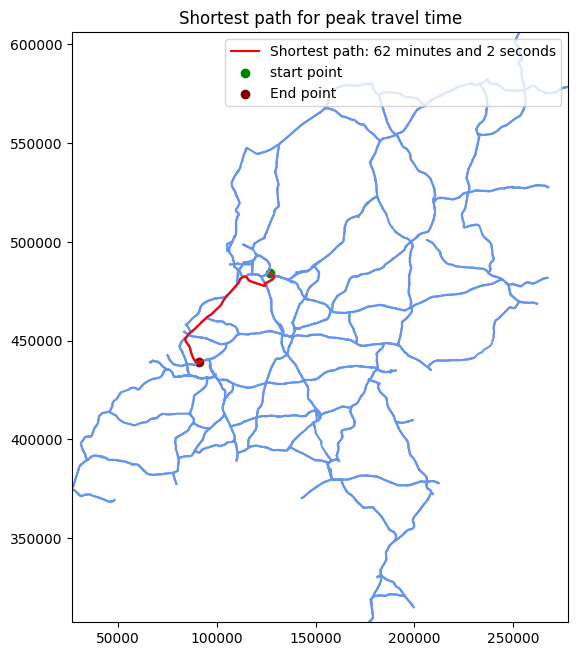

In [33]:
fig = plot_shortest_path(p1, p2, time_str='peak')